# Determine the amount of neutralizing activity directed towards the RBD elicited by infection with Delta variant

## Set up analysis
Import packages

In [1]:
import os
import re
import warnings

from IPython.display import display, HTML

import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt
import natsort

import numpy as np
import pandas as pd
from plotnine import *
import seaborn

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import lifelines
import sklearn
import scipy.stats
from statistics import geometric_mean

import yaml

print(f"Using `neutcurve` version {neutcurve.__version__}")

Using `neutcurve` version 0.5.7


Use seaborn theme and change font:

In [2]:
theme_set(theme_seaborn(style='white', context='talk', font='FreeSans', font_scale=1))
plt.style.use('seaborn-white')

Read in config file

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Define results directory

In [4]:
resultsdir = 'results/rbd_depletion_neuts'
os.makedirs(resultsdir, exist_ok=True)

## Read in fracinfect file and plot curves

Read in the neut data for all experiments for this paper, but only select the date(s) that correspond to the RBD depletions experiment. Note that this is only configured to handle one experiment date currently (because the amazingly talented Rachel Eguia ran all these assays on a single date). So for future projects, this might need to be adjusted. 

In [5]:
rbd_depletions_date = [str(i) for i in config['rbd_depletions_date']]
heterologous_depletions_dates = [str(i) for i in config['heterologous_depletions_dates']]
print(f'Getting data from {rbd_depletions_date}')

frac_infect = (pd.read_csv(config['aggregate_fract_infect_csvs'])
               .query('date in @rbd_depletions_date')
               .assign(virus=lambda x: np.where((x['virus']=="mock depletion (D614G spike)") & (x['date'].isin(heterologous_depletions_dates)), 
                                                'heterologous mock depletion (D614G spike)',
                                                x['virus']
                                               )
                      )
               .assign(virus=lambda x: np.where((x['virus']=="Delta RBD antibodies depleted x D614G spike PV"), 
                                                'heterologous Ab depletion (D614G spike)',
                                                x['virus']
                                               )
                      )
              )

fits = neutcurve.CurveFits(frac_infect)

fitparams = (
    fits.fitParams()
    .assign(spike=lambda x: np.where(x['virus'].str.contains('D614G'), 'D614G', 'Delta'))
    .assign(spike=lambda x: np.where(x['virus'].str.contains('heterologous'), 'Delta dep x D614G PV', x['spike']))
    # get columns of interest
    [['serum', 'virus', 'ic50', 'ic50_bound', 'spike']]
    .assign(NT50=lambda x: 1/x['ic50'])
    .assign(depletion=lambda x: np.where(x['virus'].str.contains('mock'), 'mock depletion', 'RBD antibodies depleted'))
    )

# couldn't get lambda / conditional statement to work with assign, so try it here:
fitparams['ic50_is_bound'] = fitparams['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)

display(HTML(fitparams.head().to_html(index=False)))

Getting data from ['2021-11-12', '2021-11-25', '2021-12-12', '2021-12-22', '2022-01-06']


/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/neutcurve/hillcurve.py:741: RuntimeWarning: invalid value encountered in power
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/neutcurve/hillcurve.py:451: RuntimeWarning: invalid value encountered in sqrt


serum,virus,ic50,ic50_bound,spike,NT50,depletion,ic50_is_bound
Delta_10,heterologous mock depletion (D614G spike),0.001134,interpolated,Delta dep x D614G PV,882.157389,mock depletion,False
Delta_10,heterologous Ab depletion (D614G spike),0.040000,lower,Delta dep x D614G PV,25.000000,RBD antibodies depleted,True
Delta_10,mock depletion (D614G spike),0.001088,interpolated,D614G,918.856380,mock depletion,False
Delta_10,RBD antibodies depleted (D614G spike),0.040000,lower,D614G,25.000000,RBD antibodies depleted,True
Delta_10,mock depletion (Delta spike),0.000322,interpolated,Delta,3102.893168,mock depletion,False


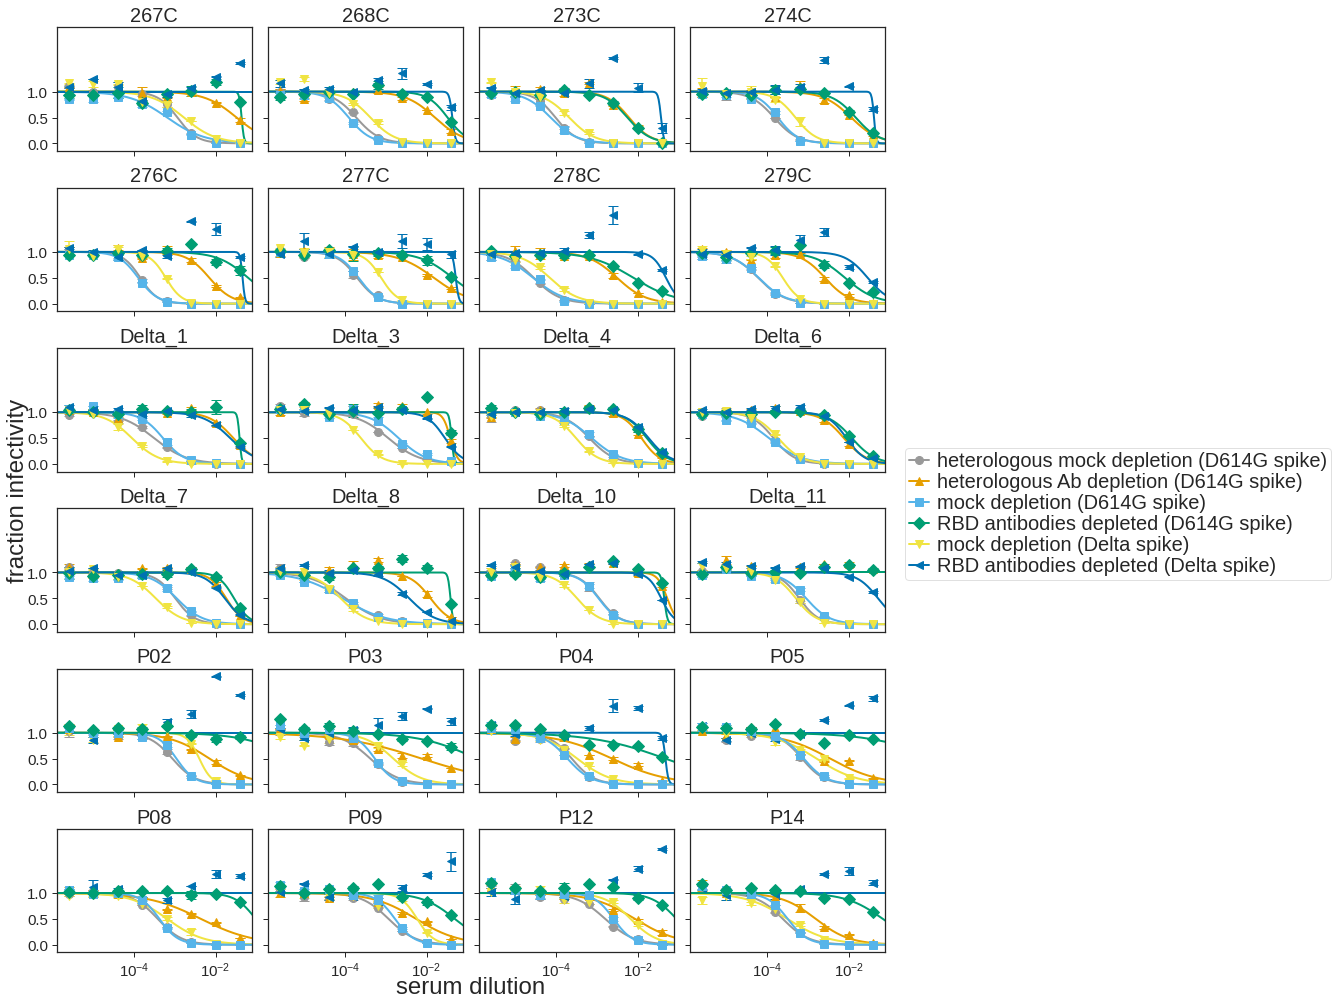

In [6]:
non_neut=[]

fig, axes = fits.plotSera(sera=natsort.natsorted(fitparams.query('serum not in @non_neut')['serum'].unique()),
                          xlabel='serum dilution',
                          ncol=4,
                          widthscale=1,
                          heightscale=1,
                          titlesize=20, labelsize=24, ticksize=15, legendfontsize=20, yticklocs=[0,0.5,1],
                          markersize=8, linewidth=2,
                          max_viruses_per_subplot=8,
                         )

plotfile = PdfPages(f'{resultsdir}/sera_frac_infectivity.pdf')
plotfile.savefig(bbox_inches='tight', transparent=True)
plotfile.close()

In [7]:
# define which sera to exclude from downstream analyses
exclude_sera = []

In [8]:
sample_key = pd.read_csv(config['sample_key_file'])

foldchange = (
    fitparams
    .query('serum not in @exclude_sera')
    .pivot_table(values='ic50', index=['serum','spike'], columns=['depletion'])
    .reset_index()
    .rename(columns={'RBD antibodies depleted': 'post-depletion_ic50', 'mock depletion': 'pre-depletion_ic50'})
    .assign(fold_change=lambda x: x['post-depletion_ic50'] / x['pre-depletion_ic50'],
            percent_RBD= lambda x: ((1-1/x['fold_change'])*100).astype(int),
            NT50_pre=lambda x: 1/x['pre-depletion_ic50'],
            NT50_post=lambda x: 1/x['post-depletion_ic50'],
           )
    .merge((fitparams
            .query('depletion=="RBD antibodies depleted"')
            [['serum', 'spike','ic50_is_bound']]
            .drop_duplicates()
           ), 
           on=['serum','spike'],
           how='left',
          )
    .assign(perc_RBD_str = lambda x: x['percent_RBD'].astype(str)
           )
    .rename(columns={'ic50_is_bound': 'post_ic50_bound'})
    .merge(fitparams)
    .assign(depletion=lambda x: pd.Categorical(x['depletion'], categories=['mock depletion', 'RBD antibodies depleted'], ordered=True))
    .merge(sample_key[['subject_name', 'sample_type']].rename(columns={'subject_name':'serum'}), 
           on='serum'
          )
    )

foldchange['perc_RBD_str'] = np.where(foldchange['post_ic50_bound'], '>'+foldchange['perc_RBD_str']+'%', foldchange['perc_RBD_str']+'%')
display(HTML(foldchange.head().to_html(index=False)))

serum,spike,post-depletion_ic50,pre-depletion_ic50,fold_change,percent_RBD,NT50_pre,NT50_post,post_ic50_bound,perc_RBD_str,virus,ic50,ic50_bound,NT50,depletion,ic50_is_bound,sample_type
267C,D614G,0.040000,0.000645,62.002654,98,1550.066341,25.00000,True,>98%,mock depletion (D614G spike),0.000645,interpolated,1550.066341,mock depletion,False,Delta breakthrough
267C,D614G,0.040000,0.000645,62.002654,98,1550.066341,25.00000,True,>98%,RBD antibodies depleted (D614G spike),0.040000,lower,25.000000,RBD antibodies depleted,True,Delta breakthrough
267C,Delta,0.040000,0.001664,24.043240,95,601.081003,25.00000,True,>95%,mock depletion (Delta spike),0.001664,interpolated,601.081003,mock depletion,False,Delta breakthrough
267C,Delta,0.040000,0.001664,24.043240,95,601.081003,25.00000,True,>95%,RBD antibodies depleted (Delta spike),0.040000,lower,25.000000,RBD antibodies depleted,True,Delta breakthrough
267C,Delta dep x D614G PV,0.032963,0.001152,28.603933,96,867.751512,30.33679,False,96%,heterologous mock depletion (D614G spike),0.001152,interpolated,867.751512,mock depletion,False,Delta breakthrough


In [9]:
print(len(foldchange))

144


In [10]:
foldchange['sample_type'].unique()

array(['Delta breakthrough', 'primary Delta infection', 'Pfizer'],
      dtype=object)

Sort the serum names in ascending order for least to most potent against Delta spike. 

In [11]:
serum_order = (foldchange
               [['serum', 'spike', 'NT50_pre']]
               .query('spike=="Delta"')
               .sort_values(['NT50_pre'], ascending=True)
               ['serum']
               .unique()
              )

print(len(serum_order))

assert len(serum_order) == len(foldchange['serum'].unique())

24


Save `foldchange` dataframe to CSV

In [12]:
csvfile=f'{resultsdir}/RBD_depletion_NT50.csv'
print(f'Writing to {csvfile}')
foldchange.to_csv(csvfile, index=False)

Writing to results/rbd_depletion_neuts/RBD_depletion_NT50.csv


Define the ways we substitute labels for naming here: 

In [13]:
sample_type_replacement={'Pfizer': '2x BNT162b2',
                         'Delta breakthrough': 'Delta\nbreakthrough\nafter 2x mRNA',
                         'primary Delta infection': 'primary\nDelta infection',
                        }

dep_virus_replacement={'Delta':'RBD Abs dep: Delta\nspike PV neuts: Delta',
                        'D614G':'RBD Abs dep: D614G\nspike PV neuts: D614G',
                        'Delta dep x D614G PV':'RBD Abs dep: Delta\nspike PV neuts: D614G',
                       }

depletion_replacement={'mock depletion':'mock','RBD antibodies depleted': 'depleted'}

/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 9 x 6.75 in image.
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: results/rbd_depletion_neuts/NT50_trackplot.pdf


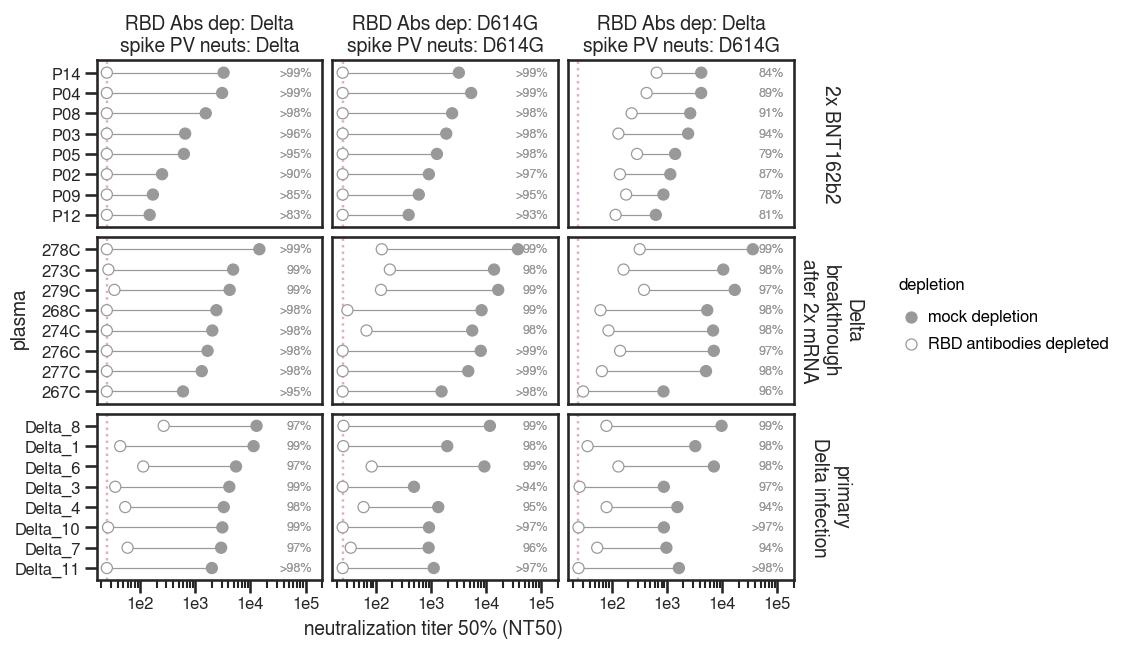

In [14]:
p = (ggplot(foldchange
            .replace(sample_type_replacement)
            .replace(dep_virus_replacement)
            .assign(
                # options are to either order sera by name or by potency    
                # serum=lambda x: pd.Categorical(x['serum'], natsort.natsorted(x['serum'].unique())[::-1], ordered=True),
                
                # let's try potency for now
                serum=lambda x: pd.Categorical(x['serum'], serum_order, ordered=True),
                spike=lambda x: pd.Categorical (x['spike'], ordered=True, categories=dep_virus_replacement.values()), 
                sample_type=lambda x: pd.Categorical(x['sample_type'], ordered=True, categories=sample_type_replacement.values()))
            , 
            aes(x='NT50',
                y='serum',
                fill='depletion',
                group='serum',
                label='perc_RBD_str',
                # color='sample_type',
               )) +
     scale_x_log10(name='neutralization titer 50% (NT50)', 
                   limits=[config['NT50_LOD'],foldchange['NT50'].max()*3.5]) +
     geom_vline(xintercept=config['NT50_LOD'], 
                linetype='dotted', 
                size=1, 
                alpha=0.6, 
                color=CBPALETTE[7]) +
     geom_line(alpha=1, color=CBPALETTE[0]) + #
     geom_point(size=4, color=CBPALETTE[0]) + #
     geom_text(aes(x=foldchange['NT50'].max()*3.5, y='serum'), #
               color=CBPALETTE[0],
               ha='right',
               size=9,
              ) +
     theme(figure_size=(3*foldchange['spike'].nunique(),0.75+0.25*foldchange['serum'].nunique()),
           axis_text=element_text(size=12),
           legend_text=element_text(size=12),
           legend_title=element_text(size=12),
           axis_title_x=element_text(size=14),
           axis_title_y=element_text(size=14, margin={'r': 16}),
           legend_position='right',
           strip_background=element_blank(),
           strip_text=element_text(size=14),
          ) +
     facet_grid('sample_type~spike', scales='free_y' )+
     ylab('plasma') +
     scale_fill_manual(values=['#999999', '#FFFFFF', ]) #+
     # scale_color_manual(values=CBPALETTE[1:]) #+
     # labs(fill = '')
    )

_ = p.draw()

p.save(f'{resultsdir}/NT50_trackplot.pdf')

/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 6 in image.
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: results/rbd_depletion_neuts/compare_RBDtargeting.pdf


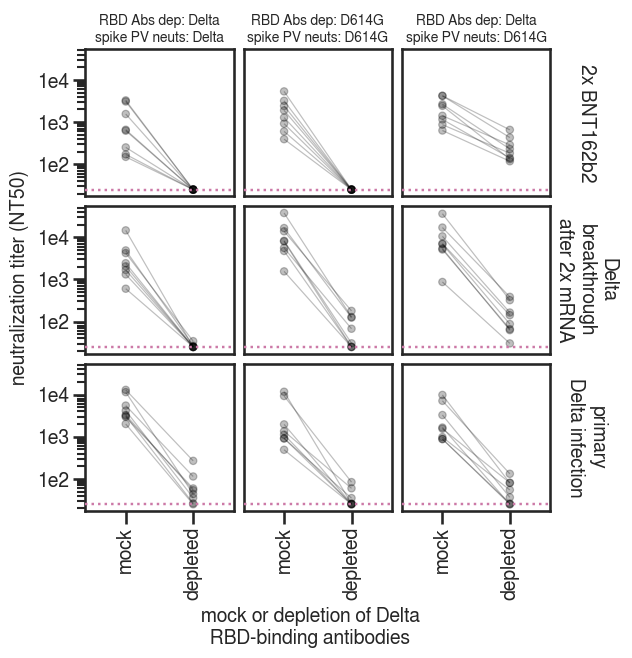

In [15]:
LOD = config['NT50_LOD']

NT50_lines = (ggplot((foldchange
                      .replace(depletion_replacement)
                      .replace(sample_type_replacement)
                      .replace(dep_virus_replacement)
                      .assign(spike=lambda x: pd.Categorical (x['spike'], 
                                                              ordered=True, 
                                                              categories=dep_virus_replacement.values()),
                              sample_type=lambda x: pd.Categorical(x['sample_type'], 
                                                                   ordered=True, 
                                                                   categories=sample_type_replacement.values()
                                                                  ),
                              depletion=lambda x: pd.Categorical(x['depletion'], 
                                                                 categories=depletion_replacement.values(), 
                                                                 ordered=True))
                     )
                     , aes(x='depletion',
                           y='NT50',
                           group='serum'
                          )
                    ) + 
              geom_point(size=2.5, alpha=0.25) +
              geom_line(alpha=0.25) +
              facet_grid('sample_type~spike') +
              theme(axis_title_y=element_text(margin={'r': 6}),
                    strip_background=element_blank(),
                    figure_size=(2*foldchange['spike'].nunique(),2*foldchange['sample_type'].nunique()),
                    axis_text_x=element_text(angle=90),
                    text=element_text(size=14),
                    strip_text_x=element_text(size=10),
                   ) +
              scale_y_log10(name='neutralization titer (NT50)') +
              xlab('mock or depletion of Delta\nRBD-binding antibodies') +
              geom_hline(yintercept=LOD,
                         color=CBPALETTE[7],
                         alpha=1,
                         size=1,
                         linetype='dotted',
                        )
             )

_ = NT50_lines.draw()
NT50_lines.save(f'{resultsdir}/compare_RBDtargeting.pdf')

/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff', '#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.75 x 2.5 in image.
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: results/rbd_depletion_neuts/compare_percentRBD.pdf
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff', '#333333ff']) for an unfilled marker ('').  Matplotlib is 

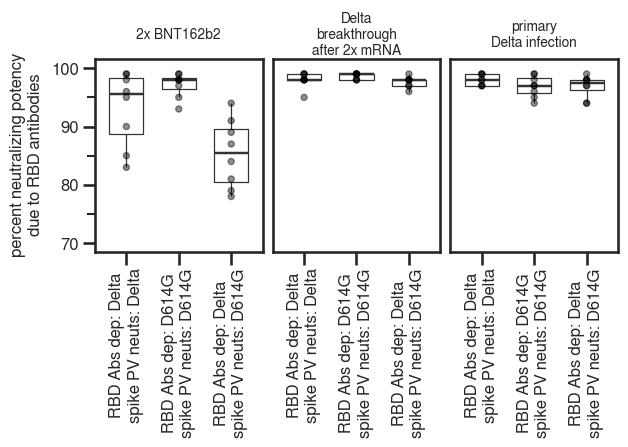

In [16]:
p = (ggplot((foldchange
             .drop(columns=['depletion', 'NT50'])
             .drop_duplicates()
             .replace(dep_virus_replacement)
             .replace(sample_type_replacement)
             .assign(spike=lambda x: pd.Categorical (x['spike'],
                                                     ordered=True,
                                                     categories=dep_virus_replacement.values()))
            )
           ) +
     aes('spike', 'percent_RBD') +
     geom_boxplot(width=0.65,
                  position=position_dodge(width=0.7),
                  outlier_shape='') +
     geom_jitter(position=position_dodge(width=0.7),
                 alpha=0.25, size=2) +
     theme(figure_size=(0.75*foldchange['spike'].nunique()*foldchange['sample_type'].nunique(),2.5),
           strip_background=element_blank(),
           axis_text_x=element_text(angle=90),
           strip_text_x=element_text(size=10),
           text=element_text(size=12),
           ) +
     facet_wrap('~sample_type')+
     scale_y_continuous(limits=[70, 100]) +
     ylab('percent neutralizing potency\ndue to RBD antibodies') +
     xlab ('')
     )

_ = p.draw()
p.save(f'{resultsdir}/compare_percentRBD.pdf')

Ok, this ^ is actually a pretty misleading plot, because most of the points are censored, so the percent RBD targeting is actually mostly a function of pre-depletion NT50 (i.e., more potent sera have more "room" to look like they are highly RBD-targeting before they hit the LOD on the low end).

The comparison we actually care about is how much *residual* neutralizing potency there is in each of the conditions. I wonder if I can just plot the post-depletion NT50...

/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_crossbar : Removed 2 rows containing missing values.
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.75 x 2.5 in image.
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: results/rbd_depletion_neuts/compare_residual_NT50.pdf
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_crossbar : Removed 2 rows containing missing values.


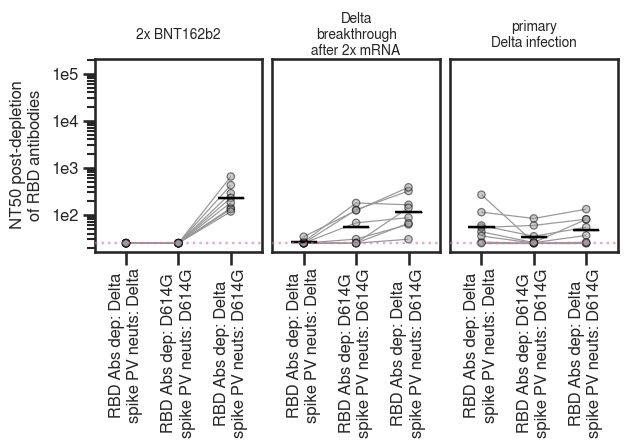

In [17]:
p = (ggplot((foldchange
             .query('depletion=="RBD antibodies depleted"')
             .drop(columns=['depletion', 'NT50'])
             .drop_duplicates()
             .replace(dep_virus_replacement)
             .replace(sample_type_replacement)
             .assign(spike=lambda x: pd.Categorical (x['spike'],
                                                     ordered=True,
                                                     categories=dep_virus_replacement.values()))
            )
           ) +
     aes('spike', 'NT50_post', group='serum') +
     geom_line(aes(x='spike', y='NT50_post', group='serum'), color=CBPALETTE[0]) +
     geom_point(size=2.5, alpha=0.5, fill=CBPALETTE[0]) + 
     geom_crossbar(data=(foldchange
                         .groupby(['spike', 'sample_type'])
                         .agg({'NT50_post': geometric_mean})
                         .reset_index()
                         .dropna()
                         .replace(dep_virus_replacement)
                         .replace(sample_type_replacement)
                        ),
                   inherit_aes=False,
                   mapping=aes(x='spike', y='NT50_post', ymin='NT50_post', ymax='NT50_post'),
                  ) +
     geom_hline(yintercept=config['NT50_LOD'], 
                linetype='dotted', 
                size=1, 
                alpha=0.6, 
                color=CBPALETTE[7]) +
     theme(figure_size=(0.75*foldchange['spike'].nunique()*foldchange['sample_type'].nunique(),2.5),
           strip_background=element_blank(),
           axis_text_x=element_text(angle=90),
           strip_text_x=element_text(size=10),
           text=element_text(size=12),
           ) +
     facet_wrap('~sample_type')+
     scale_y_log10(limits=[config['NT50_LOD'],foldchange['NT50_pre'].max()*3.5], 
                   name='NT50 post-depletion\nof RBD antibodies') +
     xlab ('')
     )

_ = p.draw()
p.save(f'{resultsdir}/compare_residual_NT50.pdf')

/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.75 x 2.5 in image.
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: results/rbd_depletion_neuts/compare_foldchange.pdf


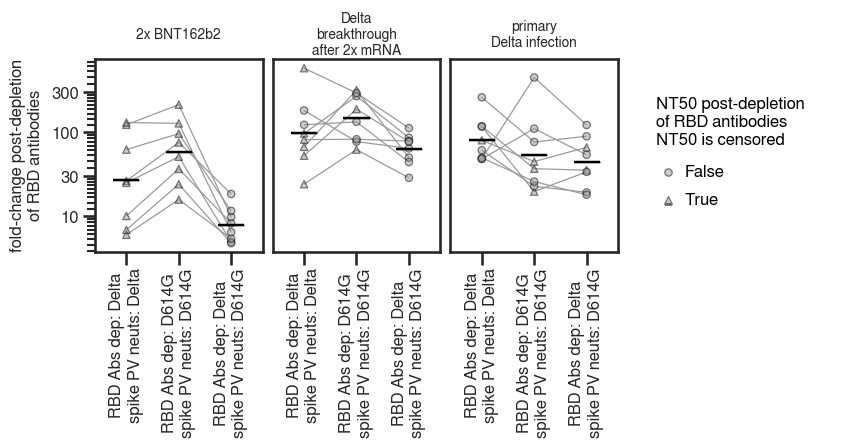

In [18]:
# what if I try plotting the fold-change IC50s?
p = (ggplot((foldchange
             .query('depletion=="RBD antibodies depleted"')
             .drop(columns=['depletion', 'NT50'])
             .drop_duplicates()
             .replace(dep_virus_replacement)
             .replace(sample_type_replacement)
             .assign(spike=lambda x: pd.Categorical (x['spike'],
                                                     ordered=True,
                                                     categories=dep_virus_replacement.values()))
            )
           ) +
     aes('spike', 'fold_change', group='serum', shape='post_ic50_bound') +
     geom_line(aes(x='spike', y='fold_change', group='serum'), color=CBPALETTE[0]) +
     geom_point(aes(shape='post_ic50_bound'),size=2.5, alpha=0.5, fill=CBPALETTE[0]) + 
     geom_crossbar(data=(foldchange
                         .groupby(['spike', 'sample_type'])
                         .agg({'fold_change': geometric_mean})
                         .reset_index()
                         .dropna()
                         .replace(dep_virus_replacement)
                         .replace(sample_type_replacement)
                        ),
                   inherit_aes=False,
                   mapping=aes(x='spike', y='fold_change', ymin='fold_change', ymax='fold_change'),
                  ) +
     theme(figure_size=(0.75*foldchange['spike'].nunique()*foldchange['sample_type'].nunique(),2.5),
           strip_background=element_blank(),
           axis_text_x=element_text(angle=90),
           strip_text_x=element_text(size=10),
           text=element_text(size=12),
           ) +
     facet_wrap('~sample_type')+
     scale_y_log10( #limits=[config['NT50_LOD'],foldchange['NT50_pre'].max()*3.5], 
                   name='fold-change post-depletion\nof RBD antibodies') +
     xlab ('')+
     scale_shape_manual(values=['o','^'],name='NT50 post-depletion\nof RBD antibodies\nNT50 is censored')
     )

_ = p.draw()
p.save(f'{resultsdir}/compare_foldchange.pdf')

In [19]:
# stat_test_df = (foldchange
#                 [['serum', 'sample_type', 'fold_change', 'percent_RBD', 'post_ic50_bound']]
#                 .drop_duplicates()
#                )

# print(f"Comparing Delta breakthrough to Pfizer")
# percent_1 = stat_test_df.query('sample_type == "Delta breakthrough"')['percent_RBD']
# percent_2 = stat_test_df.query('sample_type == "Pfizer"')['percent_RBD']
# u, p = scipy.stats.mannwhitneyu(percent_1, percent_2)
# print(f"  Mann-Whitney test:      P = {p:.2g}")
# res = lifelines.statistics.logrank_test(percent_1, percent_2)
# print(f"  Log-rank test:          P = {res.p_value:.2g}")
# censored_1 = (~stat_test_df.query('sample_type == "Delta breakthrough"')['post_ic50_bound']).astype(int)
# censored_2 = (~stat_test_df.query('sample_type == "Pfizer"')['post_ic50_bound']).astype(int)
# res = lifelines.statistics.logrank_test(percent_1, percent_2, censored_1, censored_2)
# print(f"  Log-rank test censored: P = {res.p_value:.2g}")
# # actually, Cox regression is recommended over log-rank test, see here:
# # https://lifelines.readthedocs.io/en/latest/lifelines.statistics.html
# cox_df = pd.concat([
#         pd.DataFrame({'E': censored_1, 'T': percent_1, 'groupA': 1}),
#         pd.DataFrame({'E': censored_2, 'T': percent_2, 'groupA': 0})
#         ])
# cph = lifelines.CoxPHFitter().fit(cox_df, 'T', 'E')
# print(f"  Cox proportional-hazards censored: P = {cph.summary.at['groupA', 'p']:.2g}")